# Analysing heart rate during 7 days activities
- Object: Mouse 4
- Duration: 2023-07-01 22:16:57 to 2023-07-07 23:10:45
- GA admnistration: 2023-07-05 16:00 to 21:00

In [2]:
%load_ext autoreload
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pyhrv.tools as tools
import mat73
from datetime import datetime, timedelta
import logging as log

import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

from tqdm import tqdm

In [4]:
from pyhrv import hrv
import pyhrv.time_domain as td 

In [5]:
from AdInstrumentData import AdInstrumentData

In [7]:
original_files = [
    'Mouse03 to 06_20230701 pm.mat',
    'Mouse03 to 06_20230702 am.mat',
    'Mouse03 to 06_20230702 pm.mat',
    'Mouse03 to 06_20230704 am.mat',
    'Mouse03 to 06_20230704 pm.mat',
    'Mouse03 to 06_20230705 am.mat',
    'Mouse03 to 06_20230705 pm.mat',
    'Mouse03 to 06_20230706 am.mat',
    'Mouse03 to 06_20230706 pm.mat',
    'Mouse03 to 06_20230707 am.mat',
    'Mouse03 to 06_20230707 pm.mat',
    'Mouse03 to 06_20230708 am.mat'
    
]

In [5]:
# setup
log.basicConfig(level=log.INFO)

start_time = None
finish_time = None
# duration = 3600 #1 hour
# sliding_window = 1800 # 30 minutes
duration = 600 # 10 minutes
sliding_window = 300 # 5 minutes
channel = 5
ecg = None

ecg_collections = []
calculated = {'hr_means':[], 'pnn6':[], 'sdnn':[], 'activity':[], 'val_level':[], 'from_time':[], 'to_time':[]}

In [17]:
minimum_data_validity = 0.3
minimum_nni_count = 10

def calculate_hrv(ecg):
    if ecg is not None and len(ecg['nni']) > minimum_nni_count and ecg['val_level'] > minimum_data_validity:
        hr_parameter = td.hr_parameters(nni=ecg['nni'])
        calculated['hr_means'] += [hr_parameter[0]]
        calculated['pnn6'] += [td.nnXX(nni=ecg['nni'], threshold=6)[1]]
        calculated['sdnn'] += [td.sdnn(nni=ecg['nni'])[0]]
        calculated['activity'] += [np.mean(ecg['activity'])]
    else:
        calculated['hr_means'] += [None]
        calculated['pnn6'] += [None]
        calculated['sdnn'] += [None]
        calculated['activity'] += [None]
    calculated['val_level'] += [ecg['val_level']]
    calculated['from_time'] += [ecg['from_time']]
    calculated['to_time'] += [ecg['to_time']]
    

for file in original_files:
    raw_data = AdInstrumentData([f'data/{file}'])
    print(raw_data.start_time, raw_data.finish_time)
    fetch_size = int(raw_data.fs * duration)
    loop_range = int(np.ceil(raw_data.tick_len / (sliding_window * raw_data.fs))-1)
    
    if start_time is None:
        start_time = raw_data.start_time
        finish_time = start_time + timedelta(seconds=duration)
    
    for i in tqdm(range(loop_range)):
        
        if ecg is None:
            start_time = start_time if start_time >= raw_data.start_time else raw_data.start_time
            finish_time = start_time + timedelta(seconds=duration)
            ecg = raw_data.get_data(channel, from_time=start_time, to_time=finish_time)
        elif finish_time > raw_data.start_time:
            ecg_add = raw_data.get_data(channel, to_time=finish_time)
            sc = (ecg['to_time'] - ecg['from_time']).total_seconds()
            sc_add = (ecg_add['to_time'] - ecg_add['from_time']).total_seconds()
            ecg['val_level'] = (ecg['val_level'] * sc + ecg_add['val_level'] * sc_add) / (sc + sc_add)
            ecg['nni'] = np.concatenate([ecg['nni'], ecg_add['nni']])
            ecg['activity'] = np.concatenate([ecg['activity'], ecg_add['activity']])
            ecg['to_time'] = ecg_add['to_time']
                
        if finish_time <= raw_data.finish_time:
#             ecg_collections += [ecg]
            calculate_hrv(ecg)
            start_time = start_time + timedelta(seconds=sliding_window)
            finish_time = start_time + timedelta(seconds=duration)
            ecg = None
            

INFO:root:Labchart data from 2023-07-05 11:09:58.590943 to 2023-07-05 23:09:58.590943


2023-07-05 11:09:58.590943 2023-07-05 23:09:58.590943


 83%|██████████████████████████████████       | 119/143 [05:03<00:57,  2.39s/it]WARNING:root:Cannot identify peaks,
 zero-size array to reduction operation fmin which has no identity
 v cannot be empty
100%|█████████████████████████████████████████| 143/143 [05:55<00:00,  2.49s/it]
INFO:root:Labchart data from 2023-07-05 23:10:06.994679 to 2023-07-06 11:10:06.994679


2023-07-05 23:10:06.994679 2023-07-06 11:10:06.994679


100%|█████████████████████████████████████████| 143/143 [06:35<00:00,  2.77s/it]
INFO:root:Labchart data from 2023-07-06 11:10:16.335526 to 2023-07-06 23:10:16.335526


2023-07-06 11:10:16.335526 2023-07-06 23:10:16.335526


100%|█████████████████████████████████████████| 143/143 [11:00<00:00,  4.62s/it]
INFO:root:Labchart data from 2023-07-06 23:10:25.778564 to 2023-07-07 11:10:25.778564


2023-07-06 23:10:25.778564 2023-07-07 11:10:25.778564


100%|█████████████████████████████████████████| 143/143 [06:39<00:00,  2.80s/it]
INFO:root:Labchart data from 2023-07-07 11:10:34.131446 to 2023-07-07 23:10:34.131446


2023-07-07 11:10:34.131446 2023-07-07 23:10:34.131446


100%|█████████████████████████████████████████| 143/143 [06:31<00:00,  2.74s/it]
INFO:root:Labchart data from 2023-07-07 23:10:45.667262 to 2023-07-08 11:10:45.667262


2023-07-07 23:10:45.667262 2023-07-08 11:10:45.667262


 94%|██████████████████████████████████████▋  | 135/143 [06:17<00:17,  2.15s/it]WARNING:root:Cannot correct peaks,
 arrays used as indices must be of integer (or boolean) type
100%|█████████████████████████████████████████| 143/143 [06:34<00:00,  2.76s/it]
INFO:root:Labchart data from 2023-07-08 11:10:53.354868 to 2023-07-08 23:10:53.354868


2023-07-08 11:10:53.354868 2023-07-08 23:10:53.354868


 68%|████████████████████████████▍             | 97/143 [04:02<01:38,  2.13s/it]WARNING:root:Cannot correct peaks,
 arrays used as indices must be of integer (or boolean) type
100%|█████████████████████████████████████████| 143/143 [05:45<00:00,  2.42s/it]


In [23]:
import pandas as pd
df_calculated = pd.DataFrame(calculated)

df_calculated.to_csv('7-days.csv')

In [50]:
df_calculated['hr_means'] = df_calculated['hr_means'].interpolate()
df_calculated['pnn6'] = df_calculated['pnn6'].interpolate()
df_calculated['sdnn'] = df_calculated['sdnn'].interpolate()
df_calculated['activity'] = df_calculated['activity'].interpolate()
df_calculated['activity'] = df_calculated['activity'].interpolate()
df_calculated

,hr_means,pnn6,sdnn,activity,val_level,from_time,to_time
0,439.920643,12.819120,10.325556,0.654566,0.899447,2023-07-01 22:16:57.413498,2023-07-01 22:26:57.413498
1,434.967014,12.696983,9.177281,0.307753,0.536495,2023-07-01 22:21:57.413498,2023-07-01 22:31:57.413498
2,427.102599,22.828508,11.882264,0.248042,0.456072,2023-07-01 22:26:57.413498,2023-07-01 22:36:57.413498
3,429.162106,18.546531,10.951297,0.412586,0.787730,2023-07-01 22:31:57.413498,2023-07-01 22:41:57.413498
4,435.466415,12.715944,9.390453,0.535551,0.889089,2023-07-01 22:36:57.413498,2023-07-01 22:46:57.413498
...,...,...,...,...,...,...,...
2008,338.742728,41.199295,28.493424,0.101690,0.998618,2023-07-08 22:40:53.354868,2023-07-08 22:50:53.354868
2009,400.679140,13.696172,14.248462,0.358002,0.985040,2023-07-08 22:45:53.354868,2023-07-08 22:55:53.354868
2010,409.944250,8.297180,8.042560,0.581058,0.975734,2023-07-08 22:50:53.354868,2023-07-08 23:00:53.354868
2011,441.338066,15.889710,13.268813,0.821625,0.898302,2023-07-08 22:55:53.354868,2023-07-08 23:05:53.354868


In [95]:
# extract day_labels and day_positions
df_calculated['from_time_date'] = df_calculated['from_time'].dt.date
df_calculated['from_time_time'] = df_calculated['from_time'].dt.time

day_labels, tmps = [], set()
for i in df_calculated.index:
    if df_calculated.iloc[i]['from_time_date'] not in tmps:
        tmps.add(df_calculated.iloc[i]['from_time_date'])
        day_labels += [(i, df_calculated.iloc[i]['from_time'])]
day_labels

[(0, Timestamp('2023-07-01 22:16:57.413498')),
 (21, Timestamp('2023-07-02 00:01:57.413498')),
 (307, Timestamp('2023-07-03 00:02:14.762771')),
 (594, Timestamp('2023-07-04 00:02:20.962828')),
 (881, Timestamp('2023-07-05 00:04:48.011821')),
 (1165, Timestamp('2023-07-06 00:00:06.994679')),
 (1451, Timestamp('2023-07-07 00:00:25.778564')),
 (1737, Timestamp('2023-07-08 00:00:45.667262'))]

In [382]:
# rate = 1 # to make it one hour
# results = {'hr_means':[], 'pnn6':[], 'sdnn':[], 'activity':[], 'val_level':[]}
# day_positions = []
# day_labels = []
# for i in range(int((len(calculated['hr_means'])/rate) + 1)):
#     for key in calculated.keys():
#         if key not in ['from_time', 'to_time']:
#             start = i * rate
#             end = start+rate if start+rate < len(calculated[key]) else len(calculated[key])
#             results[key] += [np.mean(calculated[key][start:end])]

In [100]:
results = df_calculated

In [99]:
# Create a colormap to map data values to background colors
colormap = plt.get_cmap('viridis')

# Normalize data values to map them to colors in the colormap
norm = Normalize(vmin=min(df_calculated['val_level']), vmax=max(df_calculated['val_level']))

# # Create a heatmap using imshow with the background colors based on data values
alpha_value = 0.2
background_colors = [colormap(norm(value), alpha=alpha_value) for value in df_calculated['val_level']]


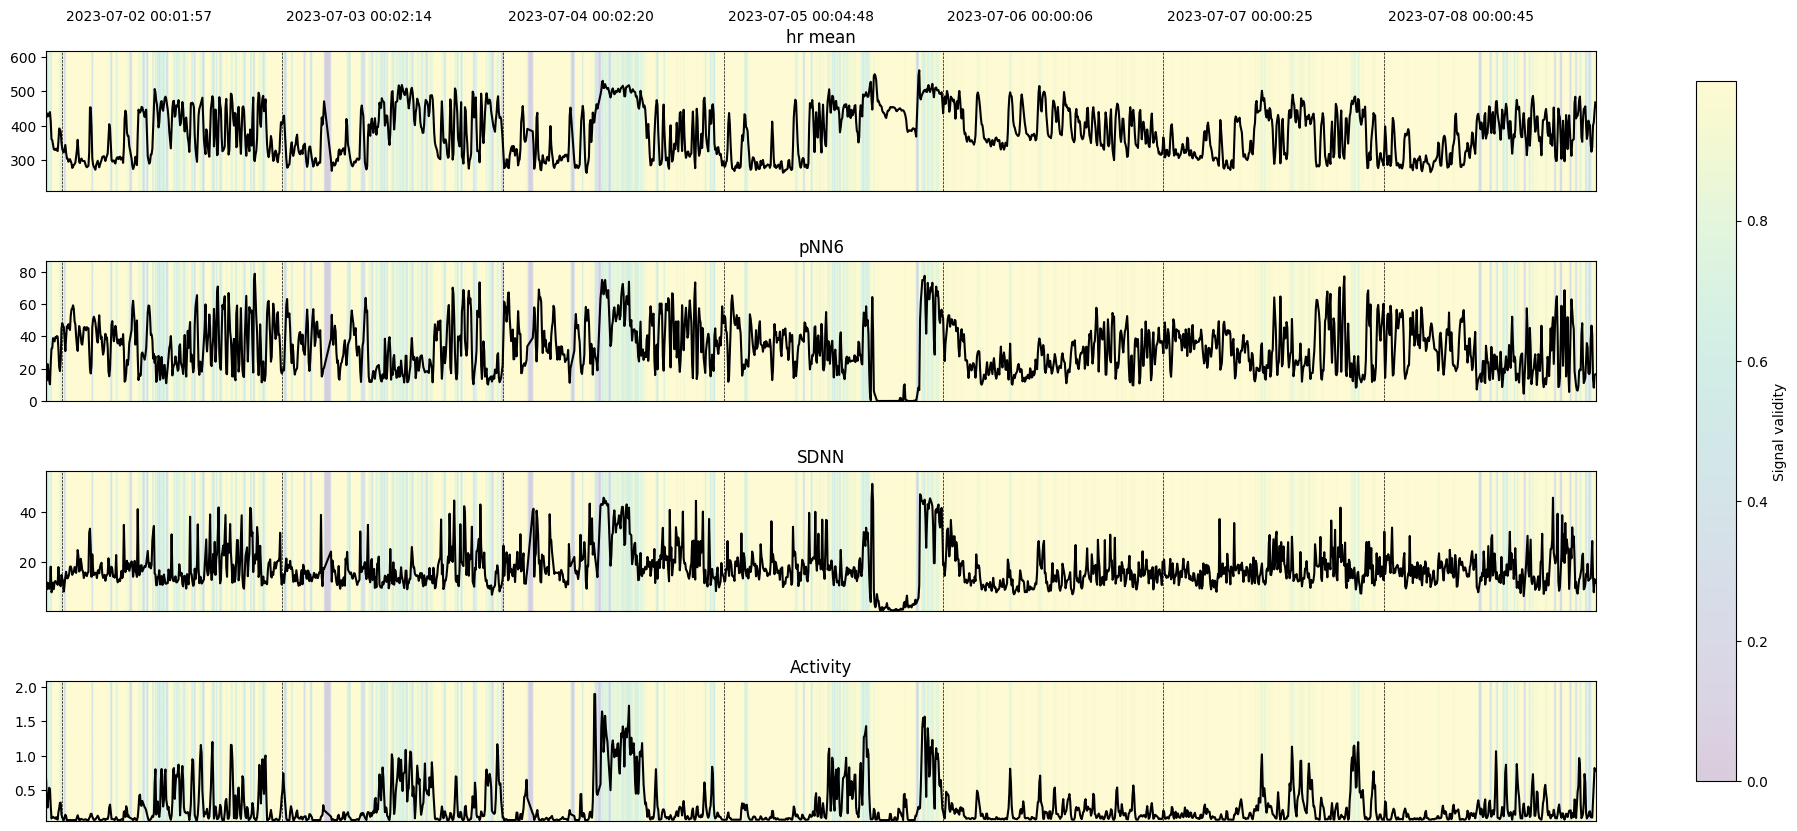

In [110]:
##### import matplotlib.pyplot as plt
from scipy import interpolate

x = np.array(range(len(results['hr_means'])))

# # multiply by 10
# xx = np.linspace(x.min(), x.max(), len(x) * 1000) 

# spl = interpolate.make_interp_spline(x, hr_means, k=5)  # type: BSpline
# hr_interpolated = spl(xx)

# # f_ecg = interpolate.interp1d(x, hr_means, kind='cubic', fill_value= 'extrapolate', )
# f_ecg = interpolate.make_interp_spline(x, hr_means)
# xx = np.arange(0, np.max(x))
# hr_interpolated = f_ecg(xx)

fig, ax = plt.subplots(4, 1, figsize=(20, 10))

multiply_high = 1.1
multiply_low = 0.8

# plt.subplot(411)
ax[0].set_title('hr mean')
ax[0].imshow([background_colors], aspect='auto', extent=[0, len(x), min(results['hr_means'])*multiply_low , max(results['hr_means'])*multiply_high])
ax[0].plot(x, results['hr_means'], color='k')
ax[0].get_xaxis().set_visible(False)
# # Add vertical lines to mark each day
for day_position, day_label in day_labels[1:]:
    ax[0].axvline(x=day_position, color='black', linestyle='--', linewidth=0.5)
    ax[0].text(day_position + 100, ax[0].get_ylim()[1]+100, str(day_label.strftime('%Y-%m-%d %H:%M:%S')), fontsize=10, ha='center', va='center')

# plt.subplot(412)
ax[1].set_title('pNN6')
ax[1].imshow([background_colors], aspect='auto', extent=[0, len(x), min(results['pnn6'])*multiply_low , max(results['pnn6'])*multiply_high])
ax[1].plot(x, results['pnn6'], color='k')
ax[1].get_xaxis().set_visible(False)
# # Add vertical lines to mark each day
for day_position, day_label in day_labels:
    ax[1].axvline(x=day_position, color='black', linestyle='--', linewidth=0.5)

# plt.subplot(413)
ax[2].set_title('SDNN')
ax[2].imshow([background_colors], aspect='auto', extent=[0, len(x), min(results['sdnn'])*multiply_low , max(results['sdnn'])*multiply_high])
ax[2].plot(x, results['sdnn'], color='k')
ax[2].get_xaxis().set_visible(False)
# # Add vertical lines to mark each day
for day_position, day_label in day_labels:
    ax[2].axvline(x=day_position, color='black', linestyle='--', linewidth=0.5)

# plt.subplot(414)
ax[3].set_title('Activity')
ax[3].imshow([background_colors], aspect='auto', extent=[0, len(x), min(results['activity'])*multiply_low , max(results['activity'])*multiply_high])
ax[3].plot(x, results['activity'], color='k')
ax[3].get_xaxis().set_visible(False)
# # Add vertical lines to mark each day
for day_position, day_label in day_labels:
    ax[3].axvline(x=day_position, color='black', linestyle='--', linewidth=0.5)

plt.xlabel('Time (h)')

plt.subplots_adjust(hspace=0.5)

# Create a colorbar legend for the colormap
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=norm), cax=cax)
cb.set_label('Signal validity')
cb.solids.set(alpha=alpha_value)

# plt.ylabel('RR-interval (ms)')

plt.show()

In [106]:
day_labels

[(0, Timestamp('2023-07-01 22:16:57.413498')),
 (21, Timestamp('2023-07-02 00:01:57.413498')),
 (307, Timestamp('2023-07-03 00:02:14.762771')),
 (594, Timestamp('2023-07-04 00:02:20.962828')),
 (881, Timestamp('2023-07-05 00:04:48.011821')),
 (1165, Timestamp('2023-07-06 00:00:06.994679')),
 (1451, Timestamp('2023-07-07 00:00:25.778564')),
 (1737, Timestamp('2023-07-08 00:00:45.667262'))]

In [161]:
import numpy as np
import pandas as pd
import scipy.stats as stats

def get_ttest(x,y,sided=1):
    return stats.ttest_ind(x, y, equal_var=False).pvalue/sided

np.random.seed(100)
N = 15
df = pd.DataFrame({'country': np.random.choice(['A','B','C'],N),
                   'test': np.random.choice([0,1], N),
                   'test2': np.random.choice([0,1], N),
                   'conversion': np.random.choice([0,1], N),
                   'sex': np.random.choice(['M','F'], N)
                  })


col_groupby = ['country', 'sex']
col_test_control = 'test'
col_effect = 'conversion'

a,b = df[col_test_control].unique()

df_pval = df.groupby(col_groupby)[col_effect].agg(['mean','std', ])

# df_pval.columns = [f'group{a}_size',f'group{b}_size',
#                    f'group{a}_mean',f'group{b}_mean']

df_pval['pvalue'] = df.groupby(col_groupby).apply(lambda dfx: get_ttest(
    dfx.loc[dfx[col_test_control] == a, col_effect],
    dfx.loc[dfx[col_test_control] == b, col_effect]))


df_pval.pipe(print)



                 mean       std  pvalue
country sex                            
A       F    0.666667  0.577350     NaN
        M    0.666667  0.577350     NaN
B       F    1.000000       NaN     NaN
        M    0.000000       NaN     NaN
C       F    0.000000  0.000000     NaN
        M    0.800000  0.447214     0.5


In [136]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Create a sample DataFrame
data = {
    'A': ['Group1', 'Group1', 'Group2', 'Group2', 'Group1'],
    'B': ['Category1', 'Category2', 'Category1', 'Category2', 'Category1'],
    'C': [10, 15, 8, 12, 9],
    'D': [22, 18, 25, 20, 23],
    'E': [35, 40, 30, 37, 36]
}

df = pd.DataFrame(data)

# Define a function to perform t-tests for C, D, and E between Category1 and Category2
def t_test(group):
    category1 = group[group['B'] == 'Category1']
    category2 = group[group['B'] == 'Category2']
    print(category1['C'])
    t_stat_c, p_value_c = ttest_ind(category1['C'], category2['C'])
    t_stat_d, p_value_d = ttest_ind(category1['D'], category2['D'])
    t_stat_e, p_value_e = ttest_ind(category1['E'], category2['E'])

    return pd.Series({'C_T-Stat': t_stat_c, 'C_P-Value': p_value_c,
                      'D_T-Stat': t_stat_d, 'D_P-Value': p_value_d,
                      'E_T-Stat': t_stat_e, 'E_P-Value': p_value_e})

# Apply the t_test function to each unique combination of 'A' and 'B'
t_test_results = df.groupby(['A', 'B']).apply(t_test)

print(t_test_results)


0    10
4     9
Name: C, dtype: int64
Series([], Name: C, dtype: int64)
2    8
Name: C, dtype: int64
Series([], Name: C, dtype: int64)
                  C_T-Stat  C_P-Value  D_T-Stat  D_P-Value  E_T-Stat  \
A      B                                                               
Group1 Category1       NaN        NaN       NaN        NaN       NaN   
       Category2       NaN        NaN       NaN        NaN       NaN   
Group2 Category1       NaN        NaN       NaN        NaN       NaN   
       Category2       NaN        NaN       NaN        NaN       NaN   

                  E_P-Value  
A      B                     
Group1 Category1        NaN  
       Category2        NaN  
Group2 Category1        NaN  
       Category2        NaN  
